<a href="https://colab.research.google.com/github/cengizmehmet/DesignPatterns/blob/main/BenchmarkNET_MLP/BenchmarkNET_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AN MLP FOR BENCHMARKING**

**Prepared by Mehmet CENGIZ**

ORCID: 0000-0003-4972-167X



---



This particular script was created to design a deep network that can predict the performance of a given system. It is aimed to help consumers to choose computer systems that fit their needs. In order to realise this, [The Standard Performance Evaluation Corporation's](https://www.spec.org) benchmarking dataset, which was presented in 2006, was selected to train the network. It is called [SPEC 2006 Dataset](https://www.spec.org/cgi-bin/osgresults?conf=cpu2006&op=form).


The dataset is quite messy even though practitioners gathered benchmark specifications in it carefully. In order to present a common script to clean the dataset, we created a [script](https://github.com/cengizmehmet/Databases/blob/master/SPEC2006/SPEC2006_Cleaner.ipynb) named *SPEC2006_Cleaner*. The cleaning process is explained in detail in the script. As a result, we obtained a [modified file](https://github.com/cengizmehmet/Databases/blob/master/SPEC2006/SPEC2006_modified.xlsx). In case you need the original file you can visit [here](https://github.com/cengizmehmet/Databases/blob/master/SPEC2006/SPEC2006_Original.csv).

### Necessary dependencies and libraries

In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from enum import Enum
from typing import Tuple
import math
from gc import callbacks

**Dependencies:**

The dependencies of this script we used can be found in [the requirements file](https://github.com/cengizmehmet/Benchmarks/blob/master/BenchmarkNET_MLP/requirements.txt).

## **DATA**

The dataset contains 22 columns. While 11 columns are string-type, 9 columns are integer-type. Except for them, there are two more columns. The columns `Result` and `Baseline` are potential target attributes and they are float-type. The problem here is that needs to be solved is to change data types to the formats that our model will accept.

### **Dataset**

**In our case, we access the dataset from our own Google Drive folder. Thus, in your study, you have to change the path where you access the dataset.**

In [55]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/SPEC/SPEC2006_modified.xlsx' # DO NOT FORGET TO CHANGE THE PATH

In [56]:
dataset = pd.read_excel(path)

In [57]:
print(dataset.columns)
print("-----")
rows, columns = dataset.shape
print("Columns: " + str(columns) + "\n" + "Rows: " + str(rows))
print("-----")
print(dataset.dtypes)

Index(['Hardware_Vendor', 'System', 'Result', 'Baseline', '#_Cores', '#_Chips',
       'Processor', 'Processor_MHz', '#_Threads', 'Auto_Parallelization',
       'Base_Pointer_Size', 'Peak_Pointer_Size', '1st_Level_Cache',
       '2nd_Level_Cache', '3rd_Level_Cache', 'Other_Cache', 'Memory',
       'Operating_System', 'File_System', 'Compiler', 'HW_Avail', 'SW_Avail'],
      dtype='object')
-----
Columns: 22
Rows: 45341
-----
Hardware_Vendor          object
System                   object
Result                  float64
Baseline                float64
#_Cores                   int64
#_Chips                   int64
Processor                object
Processor_MHz             int64
#_Threads                 int64
Auto_Parallelization     object
Base_Pointer_Size        object
Peak_Pointer_Size        object
1st_Level_Cache           int64
2nd_Level_Cache           int64
3rd_Level_Cache           int64
Other_Cache               int64
Memory                    int64
Operating_System         ob

To make sure prevent wrong inputs, enumerated column names are a reasonable solution.

In [58]:
class Column_Names(Enum):
  result = "Result"
  vendor = "Hardware_Vendor"
  system = "System"

### **Preprocessing**

As said earlier, a modified version of SPEC 2006 is going to be used. We eliminated some rows and changed some columns to make the dataset more useful for our implementation.

To train our models in this script, we selected the `Result` column as the target attribute and hence we do not need the `Baseline` column anymore. The `Result` column represents the response time of the system that is run under full capacity.

In [59]:
dataset = dataset.drop(['Baseline'], axis = 1)

**Method Name:** adjust_columns

**Parameters:** pd.DataFrame, Column_Names, bool, bool

**Return:** pd.DataFrame

This function adjusts data in columns according to user needs. If:

*   `normalize == True` then the function factorizes non-numeric columns and normalizes numeric values between [0, 1]. Besides, if the "normalize" parameter is true, the "non_numeric" value is insignificant.
*   `non_numerics == True` then the function factorizes non-numerics only
*   otherwise, the function factorizes all columns

In [60]:
def adjust_columns(dataset: pd.DataFrame, column_name: Column_Names, normalize: bool, non_numerics: bool) -> pd.DataFrame:
  i = 0
  while i < len(dataset.dtypes):
    if dataset.keys()[i] != column_name.value:
      if normalize:
        if dataset.dtypes[i] == 'O':
          dataset[dataset.keys()[i]] = pd.factorize(dataset[dataset.keys()[i]])[0]
        else:
          dataset[dataset.keys()[i]] = (dataset[dataset.keys()[i]] - dataset[dataset.keys()[i]].min()) / (dataset[dataset.keys()[i]].max() - dataset[dataset.keys()[i]].min())
      else:
        if non_numerics:
          if dataset.dtypes[i] == 'O':
            dataset[dataset.keys()[i]] = pd.factorize(dataset[dataset.keys()[i]])[0]
          else:
            if dataset.keys()[i] != column_name.value:
              dataset[dataset.keys()[i]] = pd.to_numeric(dataset[dataset.keys()[i]])[0]
        else:
          if dataset.keys()[i] != column_name.value:
            dataset[dataset.keys()[i]] = pd.factorize(dataset[dataset.keys()[i]])[0]
    i += 1
  return dataset

### **Splitting**

**Method Name:** split_data

**Parameters:** pd.DataFrame, float, bool, Column_Names

**Return:** list, list, list, list, list, list

This function splits the dataset to test and train. The parameter that holds column names is used for defining the target column. Using the `shuffle` parameter, the function shuffles the dataset or not. As a result, this produces 6 different lists that include the parts of the dataset as below:

* `train`: the training data
* `X_train`: columns of the training data without the target column
* `y_train`: the target column of the training data
* `test`: the test data
* `X_test`: columns of the test data without the target column
* `y_test`: the target column of the test data

In [61]:
def split_data(dataset: pd.DataFrame, data_split: float, shuffle: bool, target_column: Column_Names) -> Tuple[list, list, list, list, list, list]:  
  target_index = dataset.columns.get_loc(target_column.value)
  data = np.array(dataset)
  rows, columns = data.shape
  if shuffle:
    np.random.shuffle(data)
  train_size = int(data_split * rows)
  test_size = rows - train_size
  train = data[:train_size].T
  y_train = train[target_index]
  X_train = np.delete(train.T, obj = target_index, axis = 1)
  test = data[train_size:].T
  y_test = test[target_index]
  X_test = np.delete(test.T, obj = target_index, axis = 1)
  return train.T, X_train, y_train, test.T, X_test, y_test

## **MODEL**

Problem Definition

As the `Result` column has continuous values, the problem we try to solve is a regression problem, and hence, due to the nature of regression problems, `softmax` cannot be used as the activation function. Also, `accuracy` is not good for measuring performance.

**Method Name:** MLP

**Parameters:** Tuple, list[int], list[Activation_Functions]

**Return:** keras.Sequential

This function creates an MLP model according to the input shape, number of neurons, and activation functions. The parameter `layers_neurons` holds the number of neurons of each layer. The point to be noted is that the number of layers and the number of activation functions must be equal.

> Example input:
*   `input_shape` --> Tuple --> (22, )
*   `neurons_in_layers` --> List --> [1024, 1024, 2048]
*   `activations` --> List --> ['relu', 'relu', 'relu']

A model such as above has 22 neurons in the first layer and involves 3 hidden layers with 1024, 1024, and 2048 neurons in each layer respectively. Also, each hidden layer is activated using ReLU.

Due to our case, there is no need to specify the final layer. It is fixed to have a 1 output neuron with the activation function of "linear".


In [62]:
def MLP(input_shape: Tuple, neurons_in_layers: list, activations: list) -> keras.Sequential:
  count = len(neurons_in_layers)
  model = Sequential()
  model.add(Dense(units = neurons_in_layers[0], activation = activations[0], input_shape = input_shape))
  for i in range(1, count):
    model.add(Dense(units = neurons_in_layers[i], activation = activations[i]))
  model.add(Dense(units = 1, activation='linear'))
  return model

## **IMPLEMENTATION**

After that point, there are a few jobs left. First, we need to prepare the dataset and then decide on the hyperparameters. 

### Enumerated types:

We offer some metrics as enumerated. These can be used for both loss and performance metrics.

In [63]:
class Metrics(Enum):
  MAE = 'mean_absolute_error'
  MSE = 'mean_squared_error'
  RMS = 'root_mean_squared_error'

In addition, we offer some optimizers and learning rate schedules:

Each optimizer has a learning rate. In case the developer forget to specify the learning rate, `Keras` defines default values as below:

*   `SGD`: 0.01
*   `RMSPROP`: 0.001
*   `Adam`: 0.001

In [64]:
class Optimizers(Enum):
  Adam = "adam"
  Sgd = "sgd"
  Rmsprop = "rmsprop"

In [65]:
class Learning_Rate_Schedule(Enum):
  constant = 1
  time_based_decay = 2
  step_decay = 3

To prevent wrong inputs, activation functions that our models can accept must be enumerated.

In [66]:
class Activation_Functions(Enum):
  ELU = "elu"
  EXPO = "exponential"
  GELU = "gelu"
  HARD_SIGMOID = "hard_sigmoid"
  LINEAR = "linear"
  RELU = "relu"
  SELU = "selu"
  SIGMOID = "sigmoid"
  SOFTPLUS = "softplus"
  SOFTSIGN = "softsign"
  SWISH = "swish"
  TANH = "tanh"

### Parameters:

Dataset:

In [67]:
dataset = adjust_columns(dataset, Column_Names.result, False, False)
m, n = dataset.shape
data_split = 0.8

In [68]:
train, X_train, y_train, test, X_test, y_test = split_data(dataset, data_split, True, Column_Names.result)

Compiler:

In [69]:
loss = Metrics.MAE
optimizer = Optimizers.Adam
learning_rate = 0.001
lr_schedule = Learning_Rate_Schedule.time_based_decay
metrics = [Metrics.MAE.value]

Fitter:

In [70]:
epochs = 250
batch_size = 10
validation_split = 0.2
decay_drop_rate = 0.5
epoch_drop = 10.0
verbose = 1

Model:

In [71]:
input_shape = ((n - 1), )
neurons_in_layers = [1024, 512, 256, 128, 64, 32 ,16]
activations = ([Activation_Functions.RELU.value, Activation_Functions.RELU.value, Activation_Functions.RELU.value,
                Activation_Functions.RELU.value, Activation_Functions.RELU.value, Activation_Functions.RELU.value,
                Activation_Functions.RELU.value])

### Initializing:

In [72]:
model = MLP(input_shape, neurons_in_layers, activations)

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1024)              21504     
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 16)               

### Compiling and running:

In [74]:
if lr_schedule.value == 1:
  if optimizer.value == "adam":
    optimizer = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer.value == "sgd":
    optimizer = optimizers.SGD(learning_rate = learning_rate)
  elif optimizer.value == "rmsprop":
    optimizer = optimizers.RMSprop(learning_rate = learning_rate)
  model.compile(
      loss = loss.value,
      optimizer = optimizer,
      metrics = metrics
      )
  history = model.fit(
      X_train,
      y_train,
      epochs = epochs,
      batch_size = batch_size,
      verbose = verbose,
      validation_split = validation_split
      )
elif lr_schedule.value == 2:
  model.compile(
      loss = loss.value,
      optimizer = optimizer.value,
      metrics = metrics
      )  
  decay = learning_rate / epochs
  def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
  history = model.fit(
      X_train,
      y_train,
      epochs = epochs,
      validation_split = validation_split,
      batch_size = batch_size,
      callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose = 1)],
      )  
elif lr_schedule.value == 3:
  model.compile(
      loss = loss.value,
      optimizer = optimizer.value,
      metrics = metrics
      )  
  def lr_step_decay(epoch, lr):
    drop_rate = decay_drop_rate
    epochs_drop = epoch_drop
    return learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))
  history = model.fit(
      X_train,
      y_train,
      epochs = epochs,
      validation_split = validation_split,
      batch_size = batch_size,
      callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose = 1)],
      )


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/250
2902/2902 [==============================] - 11s 4ms/step - loss: 260.1501 - mean_absolute_error: 260.1501 - val_loss: 214.1141 - val_mean_absolute_error: 214.1141 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999960475132613.
Epoch 2/250
2902/2902 [==============================] - 10s 4ms/step - loss: 209.2130 - mean_absolute_error: 209.2130 - val_loss: 189.1825 - val_mean_absolute_error: 189.1825 - lr: 1.0000e-03

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009999880894717933.
Epoch 3/250
2902/2902 [==============================] - 10s 4ms/step - loss: 183.5093 - mean_absolute_error: 183.5093 - val_loss: 207.9121 - val_mean_absolute_error: 207.9121 - lr: 9.9999e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009999760570066191.
Epoch 4/250
2902/2902 [==============================] - 10s 4ms/step - loss: 166.2152 - 

## **RESULTS**

### Training results

We parse the `history` dictionary into `loss` and `validation loss`. By using them, we calculate the average losses.

In [75]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
metric = history.history['mean_absolute_error']
if lr_schedule.value != 1:
  lr = history.history['lr']
avg_loss = sum(loss_values)/len(loss_values)
avg_val_loss = sum(val_loss_values)/len(val_loss_values)
avg_metric = sum(metric)/len(metric)

In [76]:
print(avg_loss)
print(avg_val_loss)
print(avg_metric)
if lr_schedule.value != 1:
  print(min(lr))

48.957771026611326
59.77759461975098
48.95777113342285
0.00088297494


#### Visualisation


Loss and validation loss:

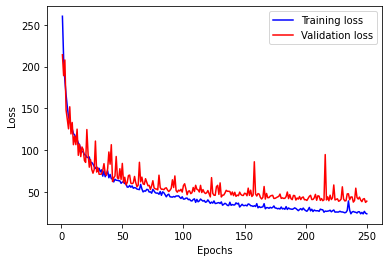

In [77]:
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Learning rate:

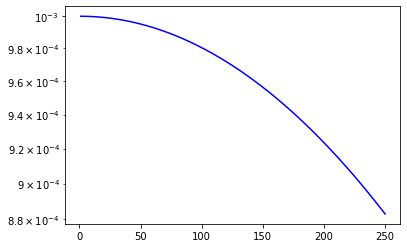

In [78]:
if lr_schedule.value != 1:
  plt.plot(epochs, lr, 'b', label='Learning Rate')
  plt.yscale('log')

### Test results

To measure the successes of tests, we decided to use `R squared` metric.

In [79]:
y_predicted = model.predict(X_test)

In [80]:
testR2Value = r2_score(y_test,y_predicted)
print("Training Set R-Square=", testR2Value)

Training Set R-Square= 0.922974953698734


#### Visualisation

And below, we present the distribution of the predicted values over true values for the MLP model.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


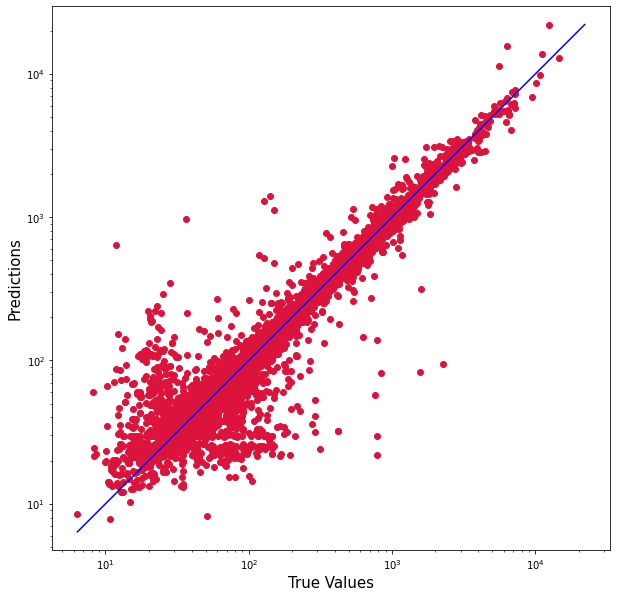

In [82]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()